## LOAD DATASET

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels
df_iowait["source"] = "CPU STRESS"
df_cpu_irq["source"] = "CPU STRESS"
df_system_msec["source"] = "CPU STRESS"
df_user_msec["source"] = "CPU STRESS"
df_cpu_util["source"] = "CPU STRESS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'cpu_stress': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'cpu_stress': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'cpu_stress': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'cpu_stress': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'cpu_stress': df_cpu_util, 'baseline': df_baseline_util_per}
}

## TUNA AND FEATURE ENGINEERING

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class TUNATimeSeriesCleaner:
    def __init__(self, instability_threshold=0.30, window_size=5):
        self.instability_threshold = instability_threshold
        self.window_size = window_size
        self.model = None
        self.scaler = StandardScaler()
        self.mean_performance = None
        
    def preprocess_nan_values(self, df, target_col, feature_cols):
        """
        Simple, robust NaN preprocessing: interpolate missing values.
        """
        df_clean = df.copy()
        all_cols = [target_col] + feature_cols
        
        for col in all_cols:
            # Use interpolation to fill NaN values
            df_clean[col] = df_clean[col].interpolate(method='linear').fillna(0)
        
        return df_clean
    
    def detect_unstable_periods(self, values):
        unstable_mask = np.zeros(len(values), dtype=bool)
        for i in range(len(values) - self.window_size + 1):
            window = values[i:i + self.window_size]
            
            # Skip windows with zero variance (constant values)
            if np.std(window) == 0:
                continue
            
            # TUNA's relative range - handle zero mean case
            window_mean = np.mean(window)
            if window_mean == 0:
                continue  # Can't calculate relative range for zero mean
                
            relative_range = (np.max(window) - np.min(window)) / window_mean
            if relative_range > self.instability_threshold:
                unstable_mask[i:i + self.window_size] = True
        return unstable_mask
    
    def create_features(self, df, target_col, feature_cols):
        features = []
        targets = []
        timestamps = []
        
        for i in range(self.window_size, len(df)):
            window_features = []
            current_values = df.iloc[i][feature_cols].values
            window_features.extend(current_values)
            
            for col in feature_cols:
                window = df[col].iloc[i-self.window_size:i]
                window_features.extend([
                    np.mean(window),
                    np.std(window),
                    np.min(window),
                    np.max(window),
                    window.iloc[-1] - window.iloc[0]
                ])
            
            current_feature_values = df.iloc[i][feature_cols].values
            if len(current_feature_values) > 1:
                window_features.extend([
                    np.mean(current_feature_values),
                    np.std(current_feature_values),
                    np.max(current_feature_values) - np.min(current_feature_values)
                ])
            
            features.append(window_features)
            targets.append(df.iloc[i][target_col])
            timestamps.append(df.index[i] if hasattr(df.index, '__getitem__') else i)
        
        return np.array(features), np.array(targets), timestamps
    
    def train_noise_model(self, X, y, unstable_mask):
        stable_idx = ~unstable_mask[self.window_size:]
        if np.sum(stable_idx) < 10:
            stable_idx = np.ones(len(X), dtype=bool)
        
        X_stable = X[stable_idx]
        y_stable = y[stable_idx]
        
        # TUNA-compliant: Skip if target is mostly idle (like TUNA skips invalid configs)
        self.mean_performance = np.mean(y_stable)
        if self.mean_performance <= 0.1:  # CPU mostly idle, skip training
            return None
        
        y_normalized = (y_stable / self.mean_performance) - 1
        
        X_scaled = self.scaler.fit_transform(X_stable)
        self.model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
        self.model.fit(X_scaled, y_normalized)
        return self.model
    
    def predict_clean_values(self, X, y_observed, unstable_mask):
        """
        Versione che usa una media pesata per preservare pattern locali
        """
        predictions = np.zeros_like(y_observed)
        
        # Create a mapping of unstable periods for the feature indices
        unstable_for_features = unstable_mask[self.window_size:self.window_size + len(X)]
        
        for i in range(len(X)):
            try:
                is_unstable = unstable_for_features[i] if i < len(unstable_for_features) else False
                if is_unstable:
                    # Preserva esattamente i valori instabili
                    predictions[i] = y_observed[i]
                else:
                    X_scaled = self.scaler.transform(X[i:i+1])
                    percent_error = self.model.predict(X_scaled)[0]
                    
                    # Ensure no NaN or inf in calculation
                    if np.isnan(percent_error) or np.isinf(percent_error):
                        predictions[i] = y_observed[i]
                    else:
                        # Predizione del modello secondo TUNA
                        model_prediction = y_observed[i] / (percent_error + 1)
                        
                        # Media pesata: 70% valore originale, 30% predizione modello
                        # Questo preserva la variabilità locale riducendo solo il rumore
                        weight_original = 0.7
                        weight_model = 0.3
                        
                        predictions[i] = weight_original * y_observed[i] + weight_model * model_prediction
            except:
                # Fallback to original value for any error
                predictions[i] = y_observed[i]
                
        return predictions
    
    def clean_csv(self, csv_path, target_col, feature_cols, time_col='Time'):
        df = pd.read_csv(csv_path)
        if time_col in df.columns:
            df[time_col] = pd.to_datetime(df[time_col])
            df = df.set_index(time_col)
        
        df = df.drop_duplicates()
        
        unstable_mask = self.detect_unstable_periods(df[target_col].values)
        X, y, timestamps = self.create_features(df, target_col, feature_cols)
        self.train_noise_model(X, y, unstable_mask)
        clean_values = self.predict_clean_values(X, y, unstable_mask)
        
        results_df = pd.DataFrame({
            'original': y,
            'cleaned': clean_values,
            'unstable': unstable_mask[self.window_size:],
            'noise_reduction': np.abs(y - clean_values)
        }, index=timestamps)
        
        return results_df

def apply_tuna(df):
    """
    TUNA algorithm that properly preserves unstable periods
    """
    df_result = df.copy()
    df_original = df.copy()
    
    cpu_columns = [col for col in df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
    
    # Statistics tracking
    feature_outlier_stats = {}
    noise_stats = {}
    total_outliers_detected = 0
    successful_models = 0
    total_noise_reduction = 0.0
    ml_corrections_applied = 0
    total_stable_points = 0
    
    for cpu_col in cpu_columns:
        print(f"  🔍 Processing {cpu_col}...")
        
        # Get feature columns (other CPUs)
        feature_cols = [col for col in cpu_columns if col != cpu_col]
        
        try:
            # Create fresh TUNA cleaner for each CPU column
            # AUMENTA WINDOW SIZE per catturare pattern più lunghi
            cleaner = TUNATimeSeriesCleaner(instability_threshold=0.50, window_size=10)  # Window più grande!
            
            # Preprocess NaN values before applying TUNA
            df_preprocessed = cleaner.preprocess_nan_values(df_original, cpu_col, feature_cols)
            
            # Apply TUNA cleaning on preprocessed data
            unstable_mask = cleaner.detect_unstable_periods(df_preprocessed[cpu_col].values)
            X, y, timestamps = cleaner.create_features(df_preprocessed, cpu_col, feature_cols)
            
            # Train model
            model_result = cleaner.train_noise_model(X, y, unstable_mask)
            
            # Skip if model training failed (idle CPU)
            if model_result is None:
                print(f"    ⏭️ {cpu_col}: Skipped (mostly idle)")
                continue
            
            # Debug: Check for NaN in data before prediction
            if np.any(np.isnan(X)) or np.any(np.isnan(y)):
                print(f"    ❌ {cpu_col}: NaN detected in features or targets, skipping")
                continue
            
            # Get clean values
            clean_values = cleaner.predict_clean_values(X, y, unstable_mask)
            
            # IMPORTANTE: Update SOLO i valori stabili!
            start_idx = cleaner.window_size
            unstable_for_features = unstable_mask[start_idx:start_idx + len(timestamps)]
            
            for i, timestamp in enumerate(timestamps):
                if unstable_for_features[i]:
                    # PRESERVA i valori originali per periodi instabili
                    df_result.loc[timestamp, cpu_col] = df_original.loc[timestamp, cpu_col]
                else:
                    # Applica cleaning SOLO ai periodi stabili
                    df_result.loc[timestamp, cpu_col] = clean_values[i]
            
            # Calculate statistics
            outliers_detected = np.sum(unstable_mask)
            stable_points = len(y) - np.sum(unstable_mask[start_idx:])
            
            # Calculate noise reduction SOLO sui punti stabili che sono stati modificati
            stable_indices = ~unstable_for_features
            if np.sum(stable_indices) > 0:
                original_stable_values = y[stable_indices]
                cleaned_stable_values = clean_values[stable_indices]
                
                original_std = np.std(original_stable_values)
                cleaned_std = np.std(cleaned_stable_values)
                noise_reduction = ((original_std - cleaned_std) / original_std) * 100 if original_std > 0 else 0
                noise_reduction = max(0, noise_reduction)
            else:
                noise_reduction = 0
            
            # Store statistics
            feature_outlier_stats[cpu_col] = {
                'outliers_detected': outliers_detected,
                'outlier_time_points': np.sum(unstable_mask),
                'relative_threshold': cleaner.instability_threshold,
                'penalty_direction': 'TUNA_ALGORITHM',
                'penalty_factor': 'ADAPTIVE'
            }
            
            noise_stats[cpu_col] = {
                'noise_reduction_percent': noise_reduction,
                'features_used': len(feature_cols),
                'model_score': cleaner.model.score(cleaner.scaler.transform(X[stable_indices]), 
                                                  (y[stable_indices] / cleaner.mean_performance) - 1) if np.sum(stable_indices) > 0 and cleaner.model else 0,
                'ml_corrections_applied': np.sum(stable_indices),  # Solo i punti stabili modificati
                'stable_points_total': stable_points
            }
            
            total_outliers_detected += outliers_detected
            successful_models += 1
            total_noise_reduction += noise_reduction
            ml_corrections_applied += np.sum(stable_indices)
            total_stable_points += stable_points
            
            print(f"    📊 {cpu_col}: {np.sum(unstable_mask)} unstable points out of {len(unstable_mask)} total ({np.mean(unstable_mask):.1%})")
            print(f"    ✅ {cpu_col}: {noise_reduction:.1f}% noise reduction (only on stable periods)")
            
        except Exception as e:
            print(f"    ❌ Error processing {cpu_col}: {str(e)}")
            noise_stats[cpu_col] = {'status': 'error', 'message': str(e)}
    
    # Add Total CPU
    df_result['Total_CPU_TUNA'] = df_result[cpu_columns].sum(axis=1)
    
    # Statistics
    avg_noise_reduction = total_noise_reduction / max(1, successful_models)
    overall_correction_rate = (ml_corrections_applied / total_stable_points * 100) if total_stable_points > 0 else 0
    
    outlier_stats = {
        'per_feature_outliers': feature_outlier_stats,
        'per_feature_noise': noise_stats,
        '_summary': {
            'total_features_processed': len(cpu_columns),
            'total_outliers': total_outliers_detected,
            'successful_noise_models': successful_models,
            'method': 'TUNA-Algorithm',
            'relative_threshold': 0.50,
            'time_window': '10pt',
            'outlier_penalty': 'algorithm_based',
            'ml_corrections_applied': ml_corrections_applied,
            'total_stable_points': total_stable_points,
            'correction_rate': overall_correction_rate,
            'noise_reduction': avg_noise_reduction
        }
    }
    
    return df_result, outlier_stats

def add_trend_features(df_tuna_cleaned):
    """
    Add essential trend features - simplified version
    """
    df_features = df_tuna_cleaned.copy()
    cpu_columns = [col for col in df_features.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
    
    print("  🕒 Adding essential trend features...")
    
    # Only essential features to avoid overfitting
    for cpu_col in cpu_columns + ['Total_CPU_TUNA']:
        # Simple trend (3-period)
        df_features[f'{cpu_col}_trend_3'] = df_features[cpu_col].rolling(3).apply(
            lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 3 else np.nan
        )
        
        # Simple momentum (3-period)
        df_features[f'{cpu_col}_momentum_3'] = df_features[cpu_col] - df_features[cpu_col].shift(3)
        
        # Z-score normalization
        rolling_mean = df_features[cpu_col].rolling(5).mean()
        rolling_std = df_features[cpu_col].rolling(5).std()
        df_features[f'{cpu_col}_zscore'] = (df_features[cpu_col] - rolling_mean) / (rolling_std + 0.001)
    
    # Essential cross-relationships
    cpu_values = df_features[cpu_columns]
    df_features['CPU_load_balance'] = cpu_values.std(axis=1) / (cpu_values.mean(axis=1) + 0.001)
    df_features['CPU_max_min_ratio'] = cpu_values.max(axis=1) / (cpu_values.min(axis=1) + 0.001)
    
    added_features = len(df_features.columns) - len(df_tuna_cleaned.columns)
    print(f"    ✅ Added {added_features} essential features")
    
    return df_features

datasets_clean = {}
all_outlier_stats = {}

print(f"\n{'='*80}")
print("APPLYING TUNA TO ALL DATASETS")
print(f"{'='*80}")

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name}...")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        # Imposta il Time come index per il groupby
        df_indexed = df.set_index('Time')
        
        # Applica TUNA
        df_clean, stats = apply_tuna(df_indexed)
        
        # Resetta l'index
        df_clean = df_clean.reset_index()
        
        # Aggiungi trend features
        df_with_features = add_trend_features(df_clean)
        
        datasets_clean[dataset_name][source_type] = df_with_features
        all_outlier_stats[dataset_name][source_type] = stats
        
        total_outliers = stats['_summary']['total_outliers']
        method = stats['_summary']['method']


APPLYING TUNA TO ALL DATASETS

📊 Processing IOWait...
  🔍 CPU STRESS:
  🔍 Processing cpu 0...
    📊 cpu 0: 481 unstable points out of 481 total (100.0%)
    ✅ cpu 0: 0.0% noise reduction (only on stable periods)
  🔍 Processing cpu 1...
    📊 cpu 1: 475 unstable points out of 481 total (98.8%)
    ✅ cpu 1: 0.0% noise reduction (only on stable periods)
  🔍 Processing cpu 2...
    📊 cpu 2: 481 unstable points out of 481 total (100.0%)
    ✅ cpu 2: 0.0% noise reduction (only on stable periods)
  🔍 Processing cpu 3...
    📊 cpu 3: 479 unstable points out of 481 total (99.6%)
    ✅ cpu 3: 0.0% noise reduction (only on stable periods)
  🔍 Processing cpu 4...
    📊 cpu 4: 479 unstable points out of 481 total (99.6%)
    ✅ cpu 4: 0.0% noise reduction (only on stable periods)
  🔍 Processing cpu 5...
    📊 cpu 5: 479 unstable points out of 481 total (99.6%)
    ✅ cpu 5: 0.0% noise reduction (only on stable periods)
  🔍 Processing cpu 6...
    📊 cpu 6: 481 unstable points out of 481 total (100.0%

## PLOTTING


COMPREHENSIVE CPU STRESS ANALYSIS - ENHANCED TUNA

🔄 Analyzing IOWait...

📊 Plotting Enhanced TUNA cleaned data for IOWait...


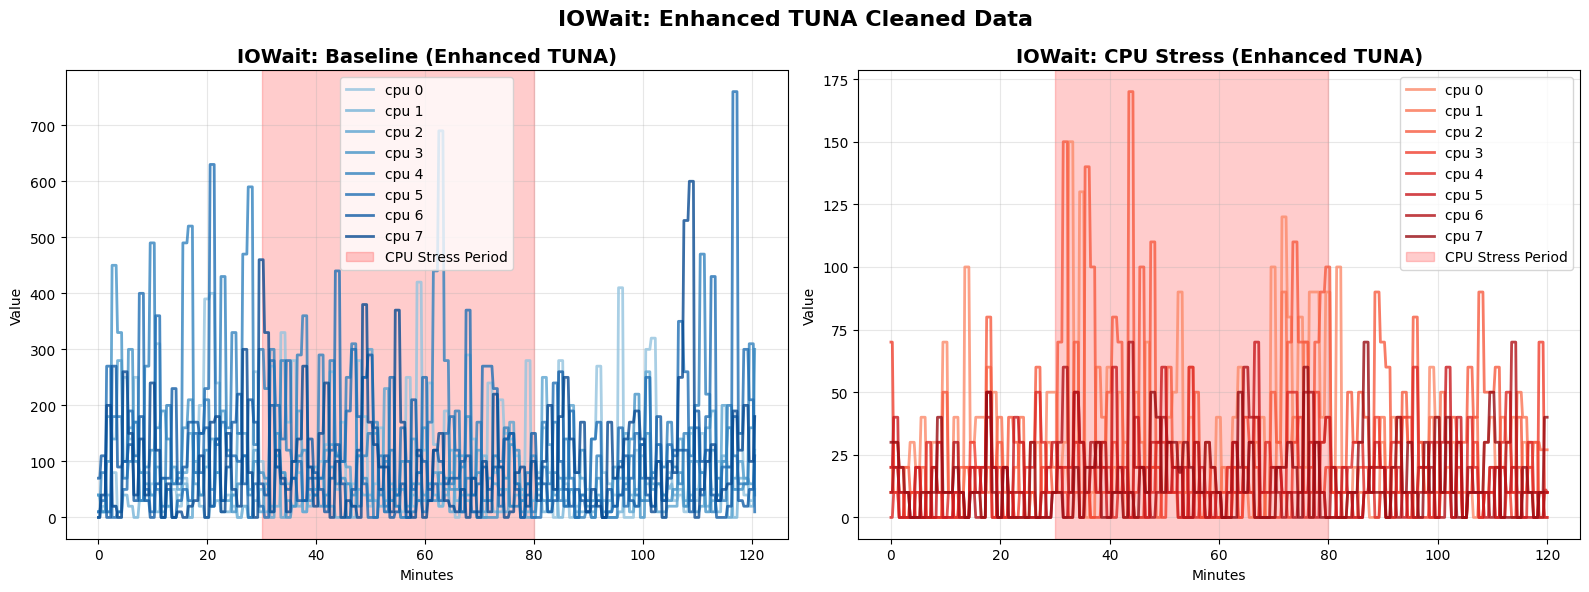

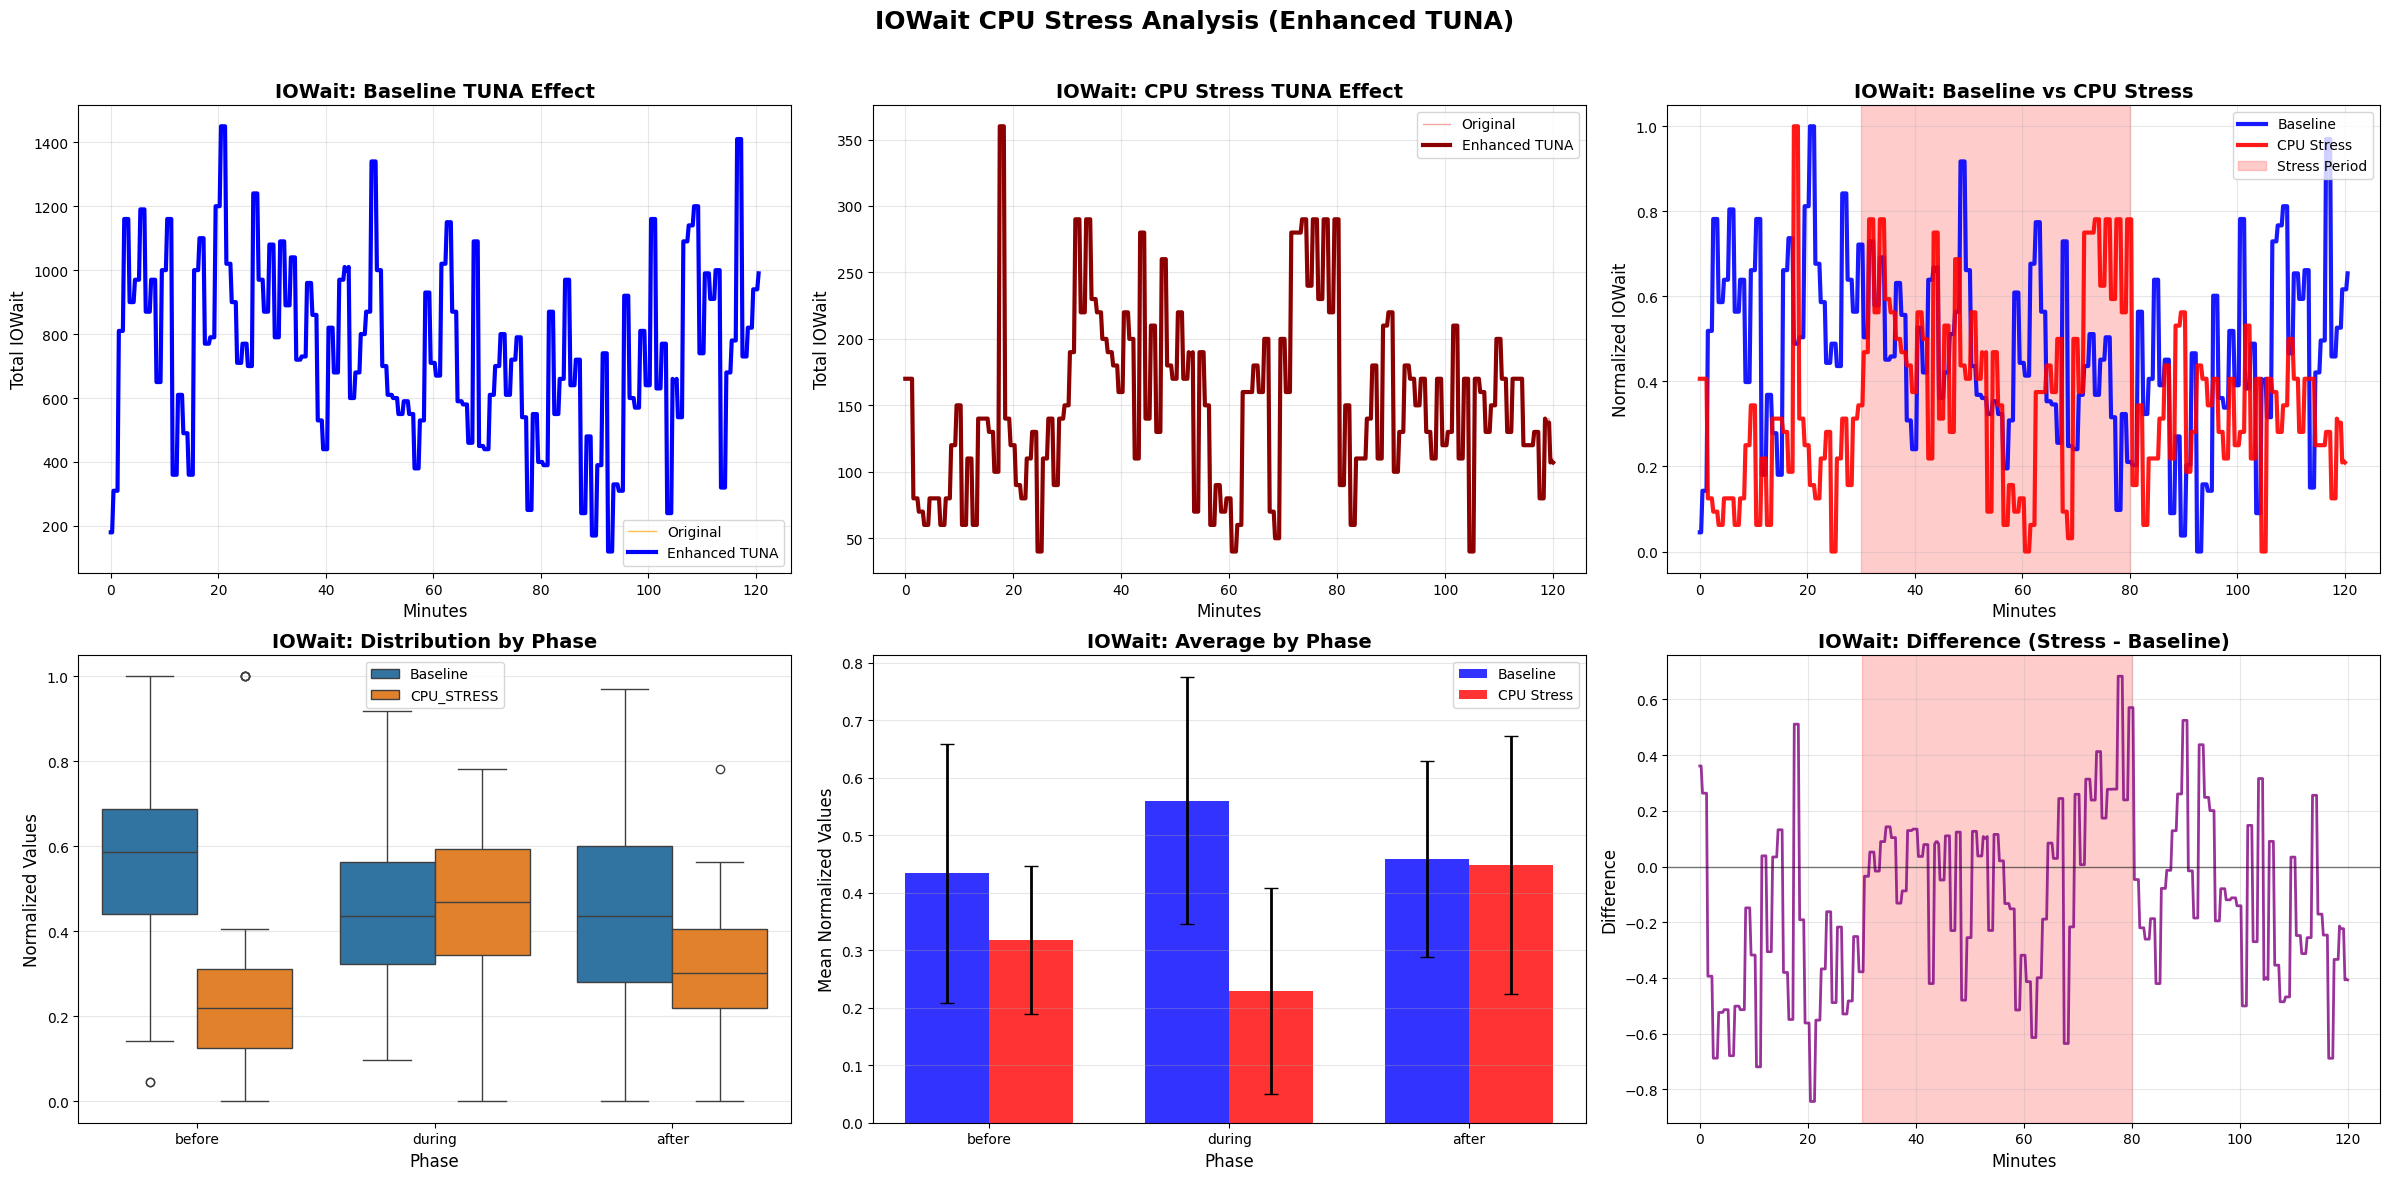

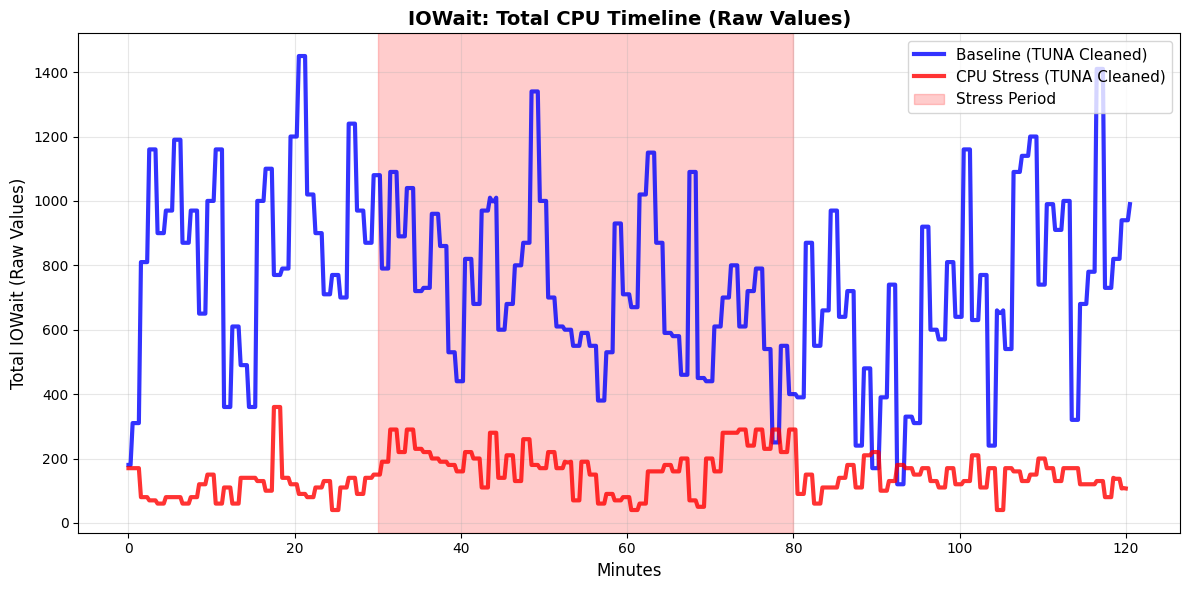


IOWAIT - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4336  0.2257  0.0000  0.9699
before  0.5596  0.2150  0.0451  1.0000
during  0.4588  0.1705  0.0977  0.9173

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.3172  0.1289  0.0  0.7812
before  0.2292  0.1788  0.0  1.0000
during  0.4479  0.2241  0.0  0.7812

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 12.95, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  0.55, p=  0.5810 (❌ NOT SIGNIFICANT)
  AFTER   : t=  5.67, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -59.05% (↘️ DECREASE)
  DURING  :   -2.39% (↘️ DECREASE)
  AFTER   :  -26.83% (↘️ DECREASE)

🔄 Analyzing IRQ...

📊 Plotting Enhanced TUNA cleaned data for IRQ...


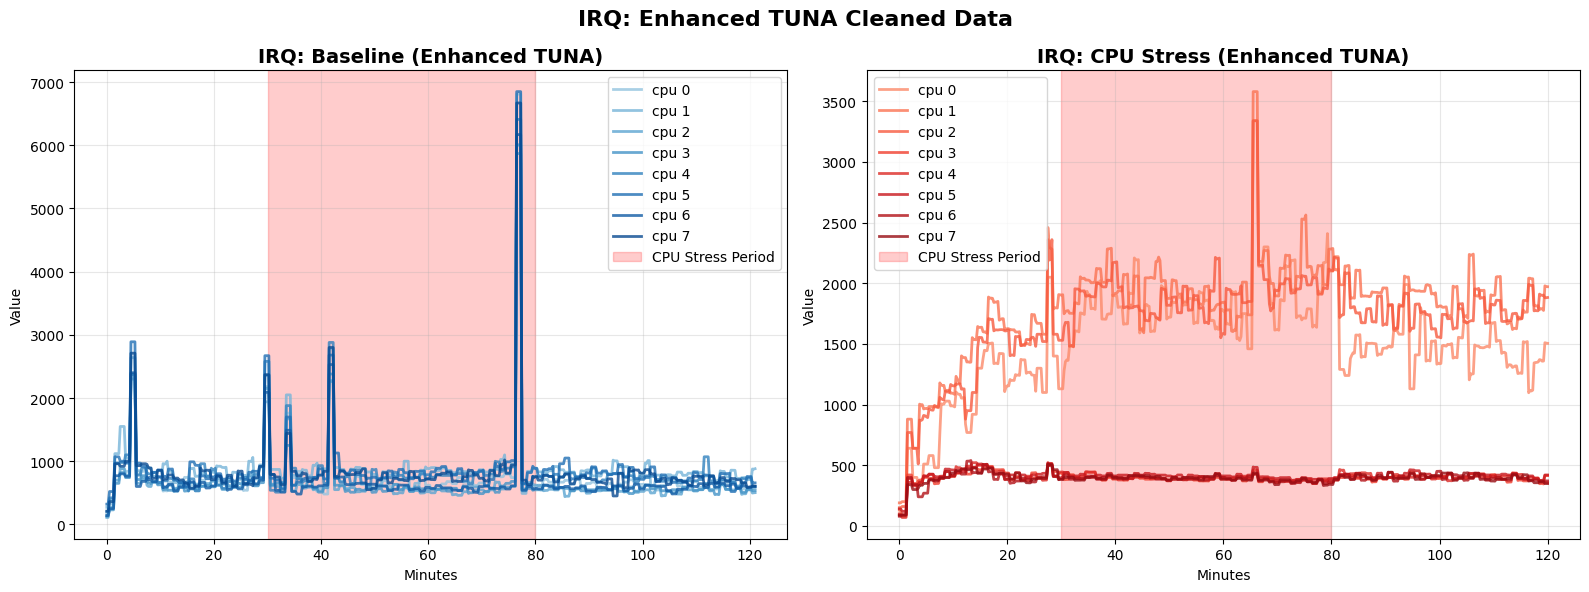

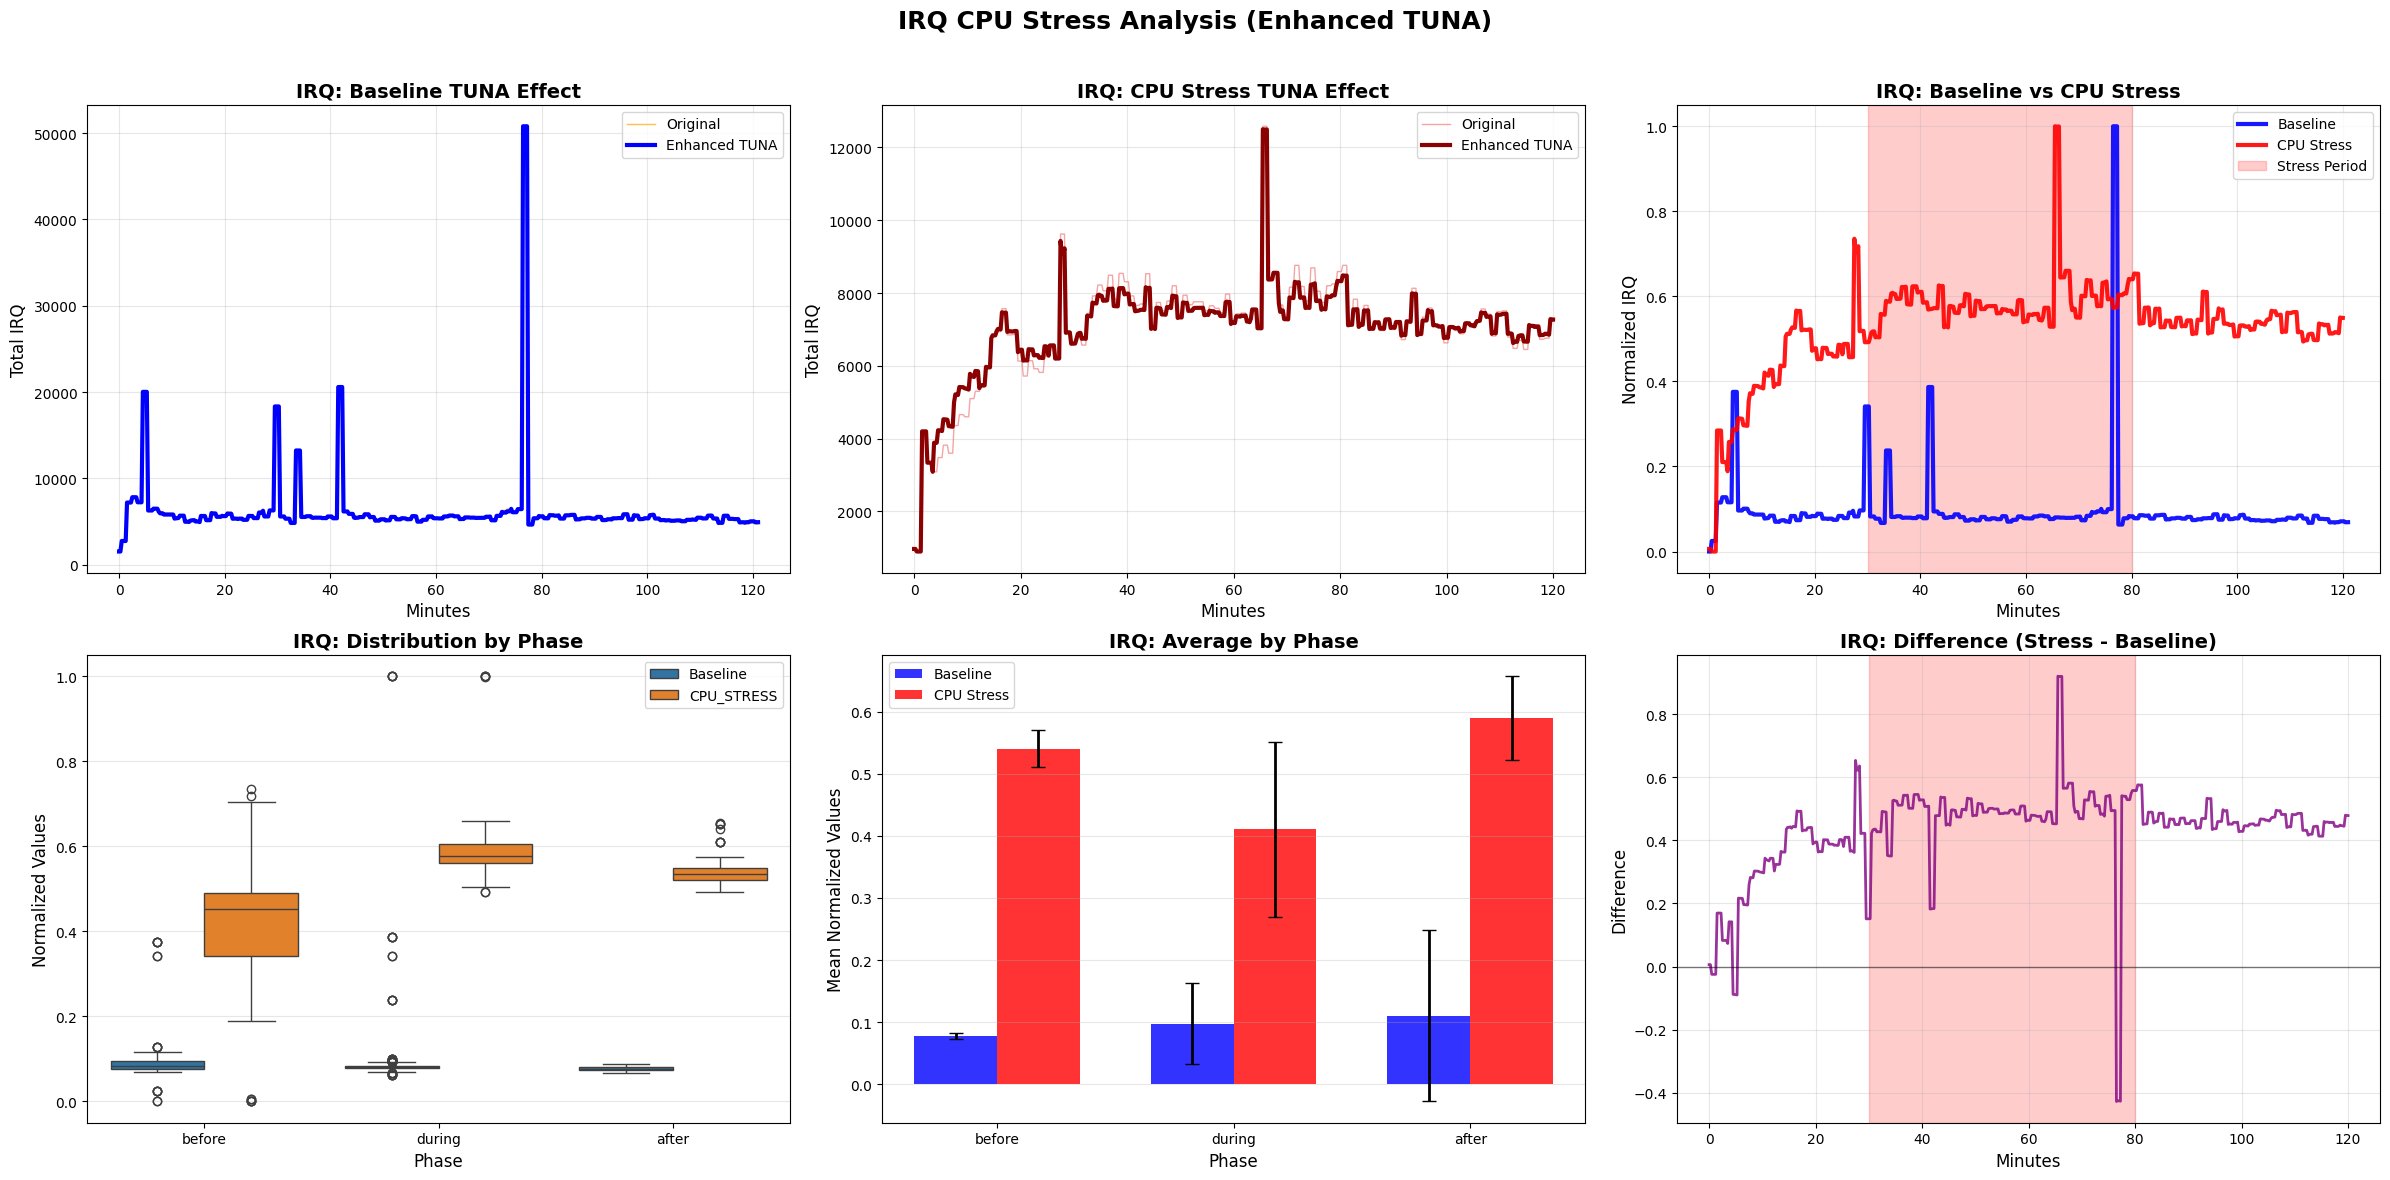

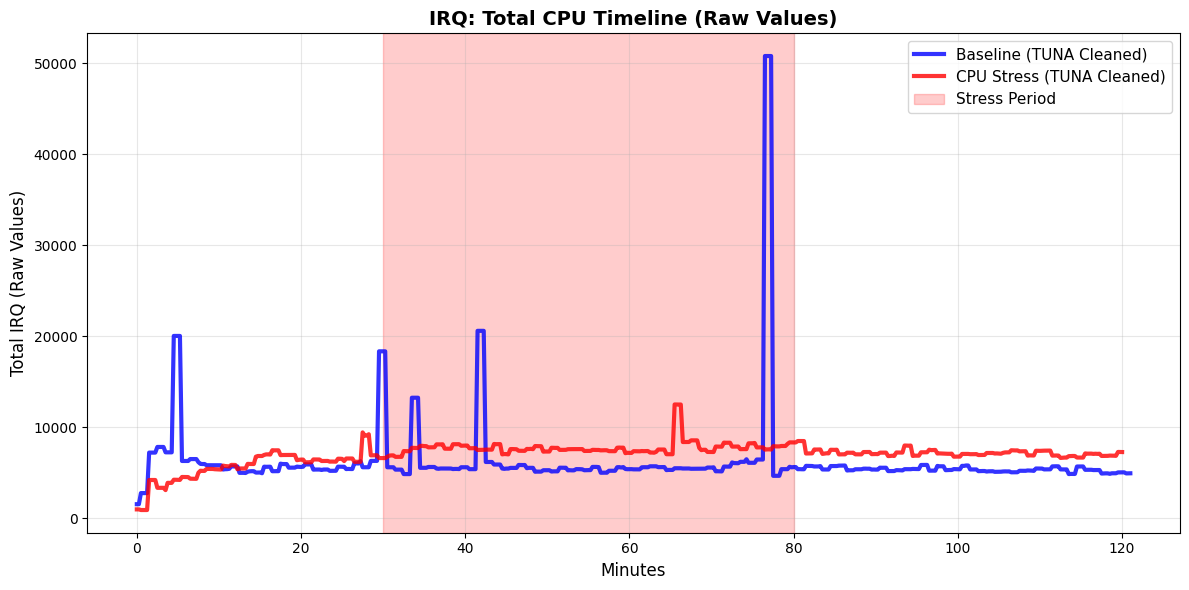


IRQ - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0775  0.0052  0.0672  0.0877
before  0.0977  0.0648  0.0000  0.3754
during  0.1107  0.1382  0.0634  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5404  0.0302  0.4937  0.6538
before  0.4106  0.1406  0.0000  0.7355
during  0.5892  0.0677  0.4922  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=-22.15, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-44.09, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=-193.46, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  : +320.36% (↗️ INCREASE)
  DURING  : +432.30% (↗️ INCREASE)
  AFTER   : +597.37% (↗️ INCREASE)

🔄 Analyzing System...

📊 Plotting Enhanced TUNA cleaned data for System...


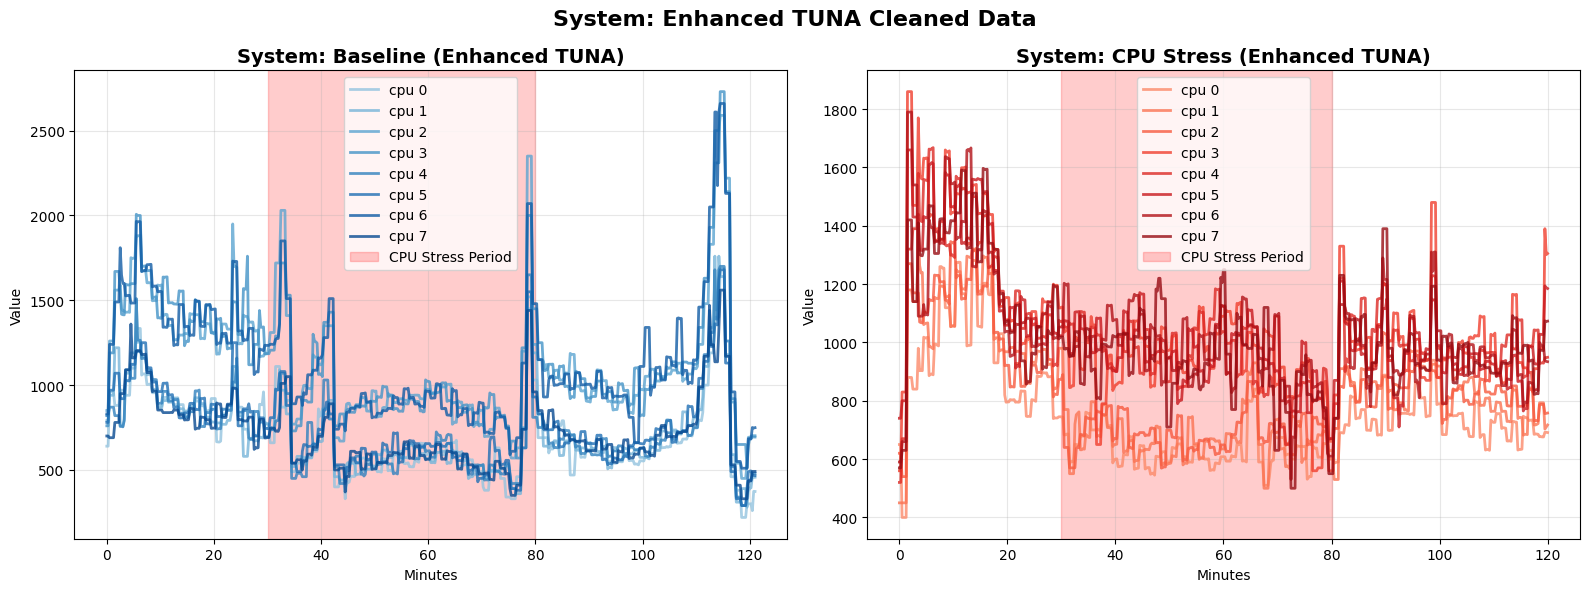

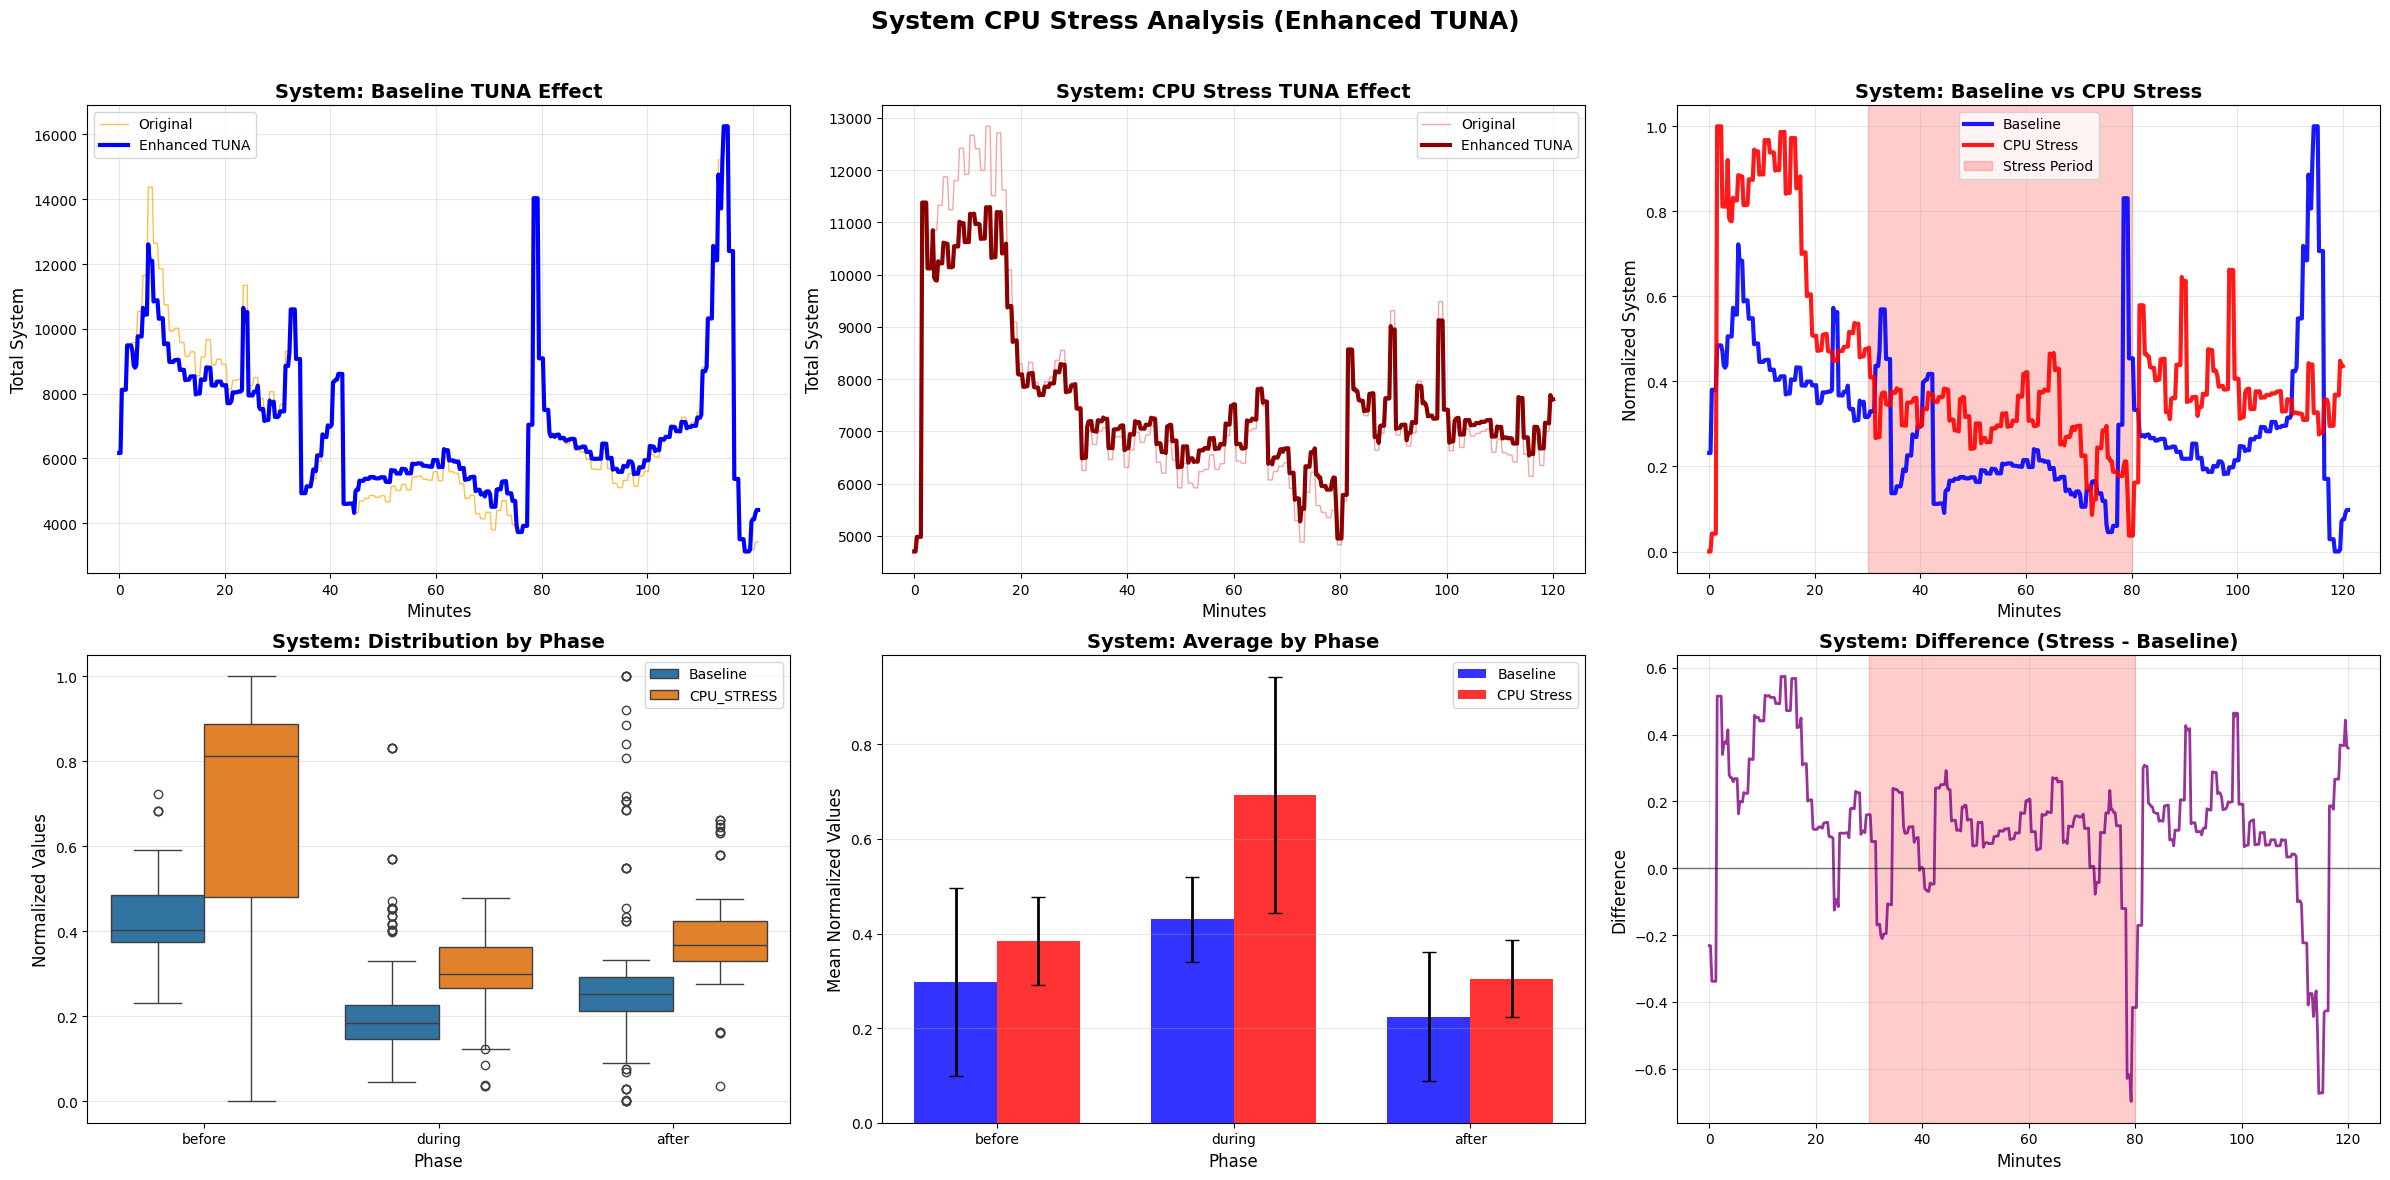

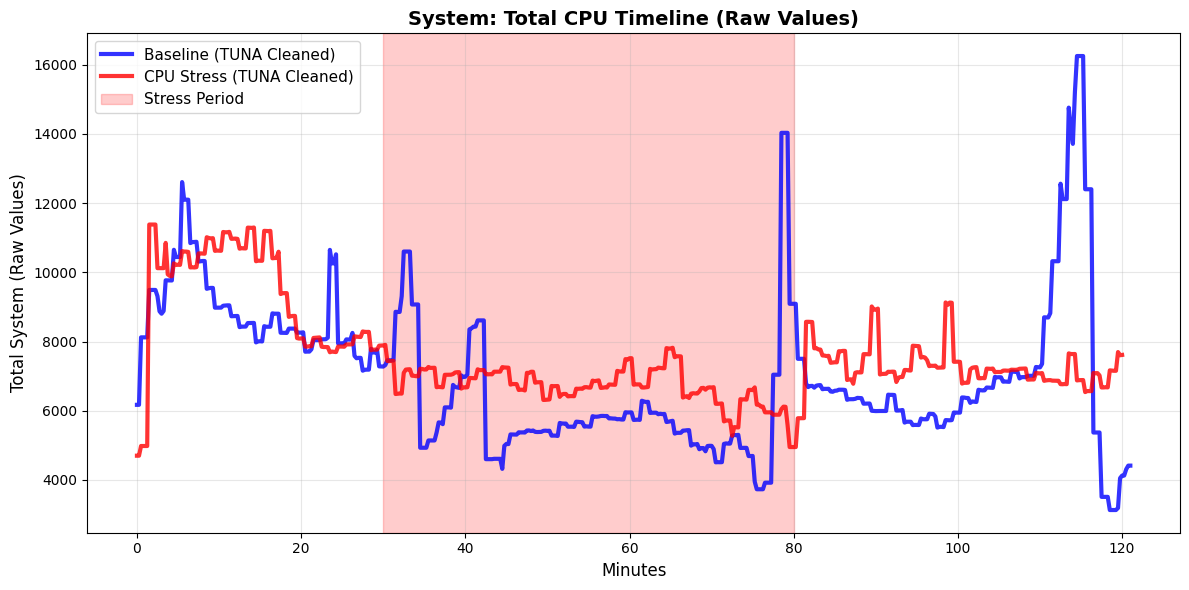


SYSTEM - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.2970  0.1985  0.0000  1.0000
before  0.4299  0.0902  0.2317  0.7223
during  0.2241  0.1365  0.0457  0.8308

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3835  0.0932  0.0374  0.6630
before  0.6926  0.2491  0.0000  1.0000
during  0.3045  0.0809  0.0374  0.4795

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=-10.86, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -7.18, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -5.00, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  +61.12% (↗️ INCREASE)
  DURING  :  +35.88% (↗️ INCREASE)
  AFTER   :  +29.13% (↗️ INCREASE)

🔄 Analyzing User...

📊 Plotting Enhanced TUNA cleaned data for User...


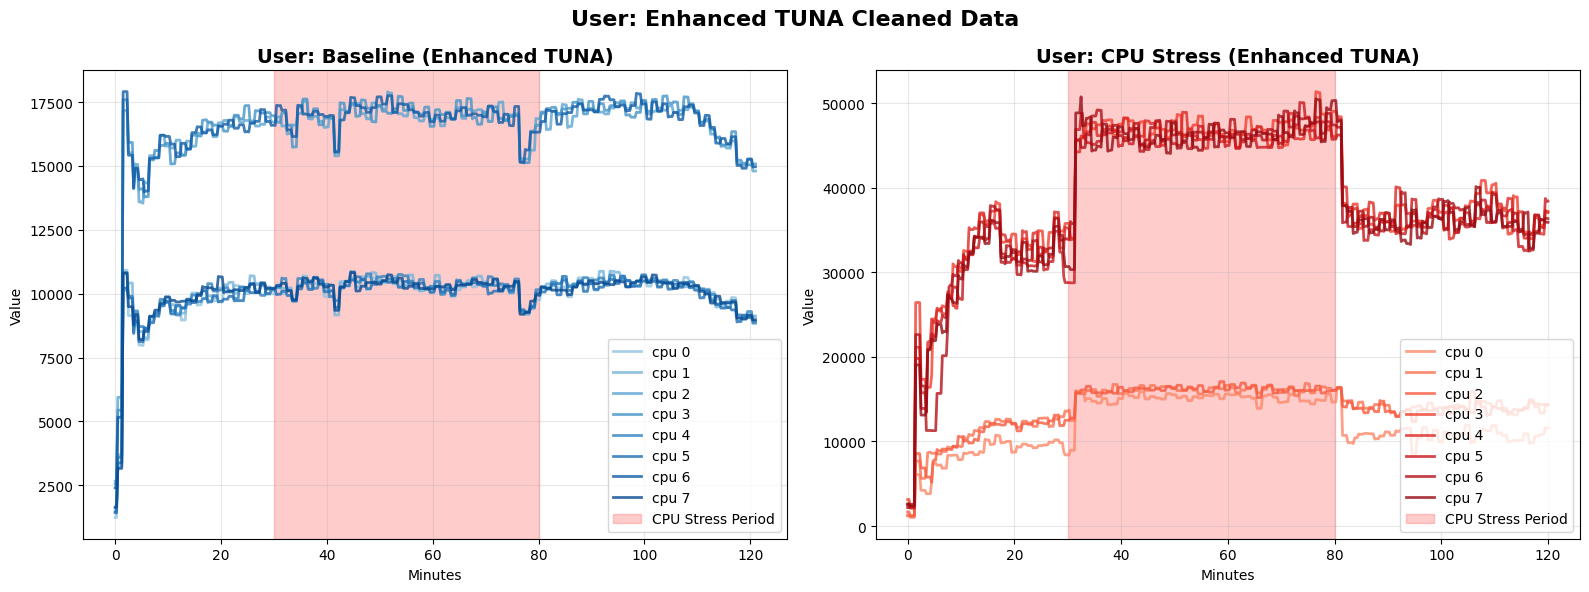

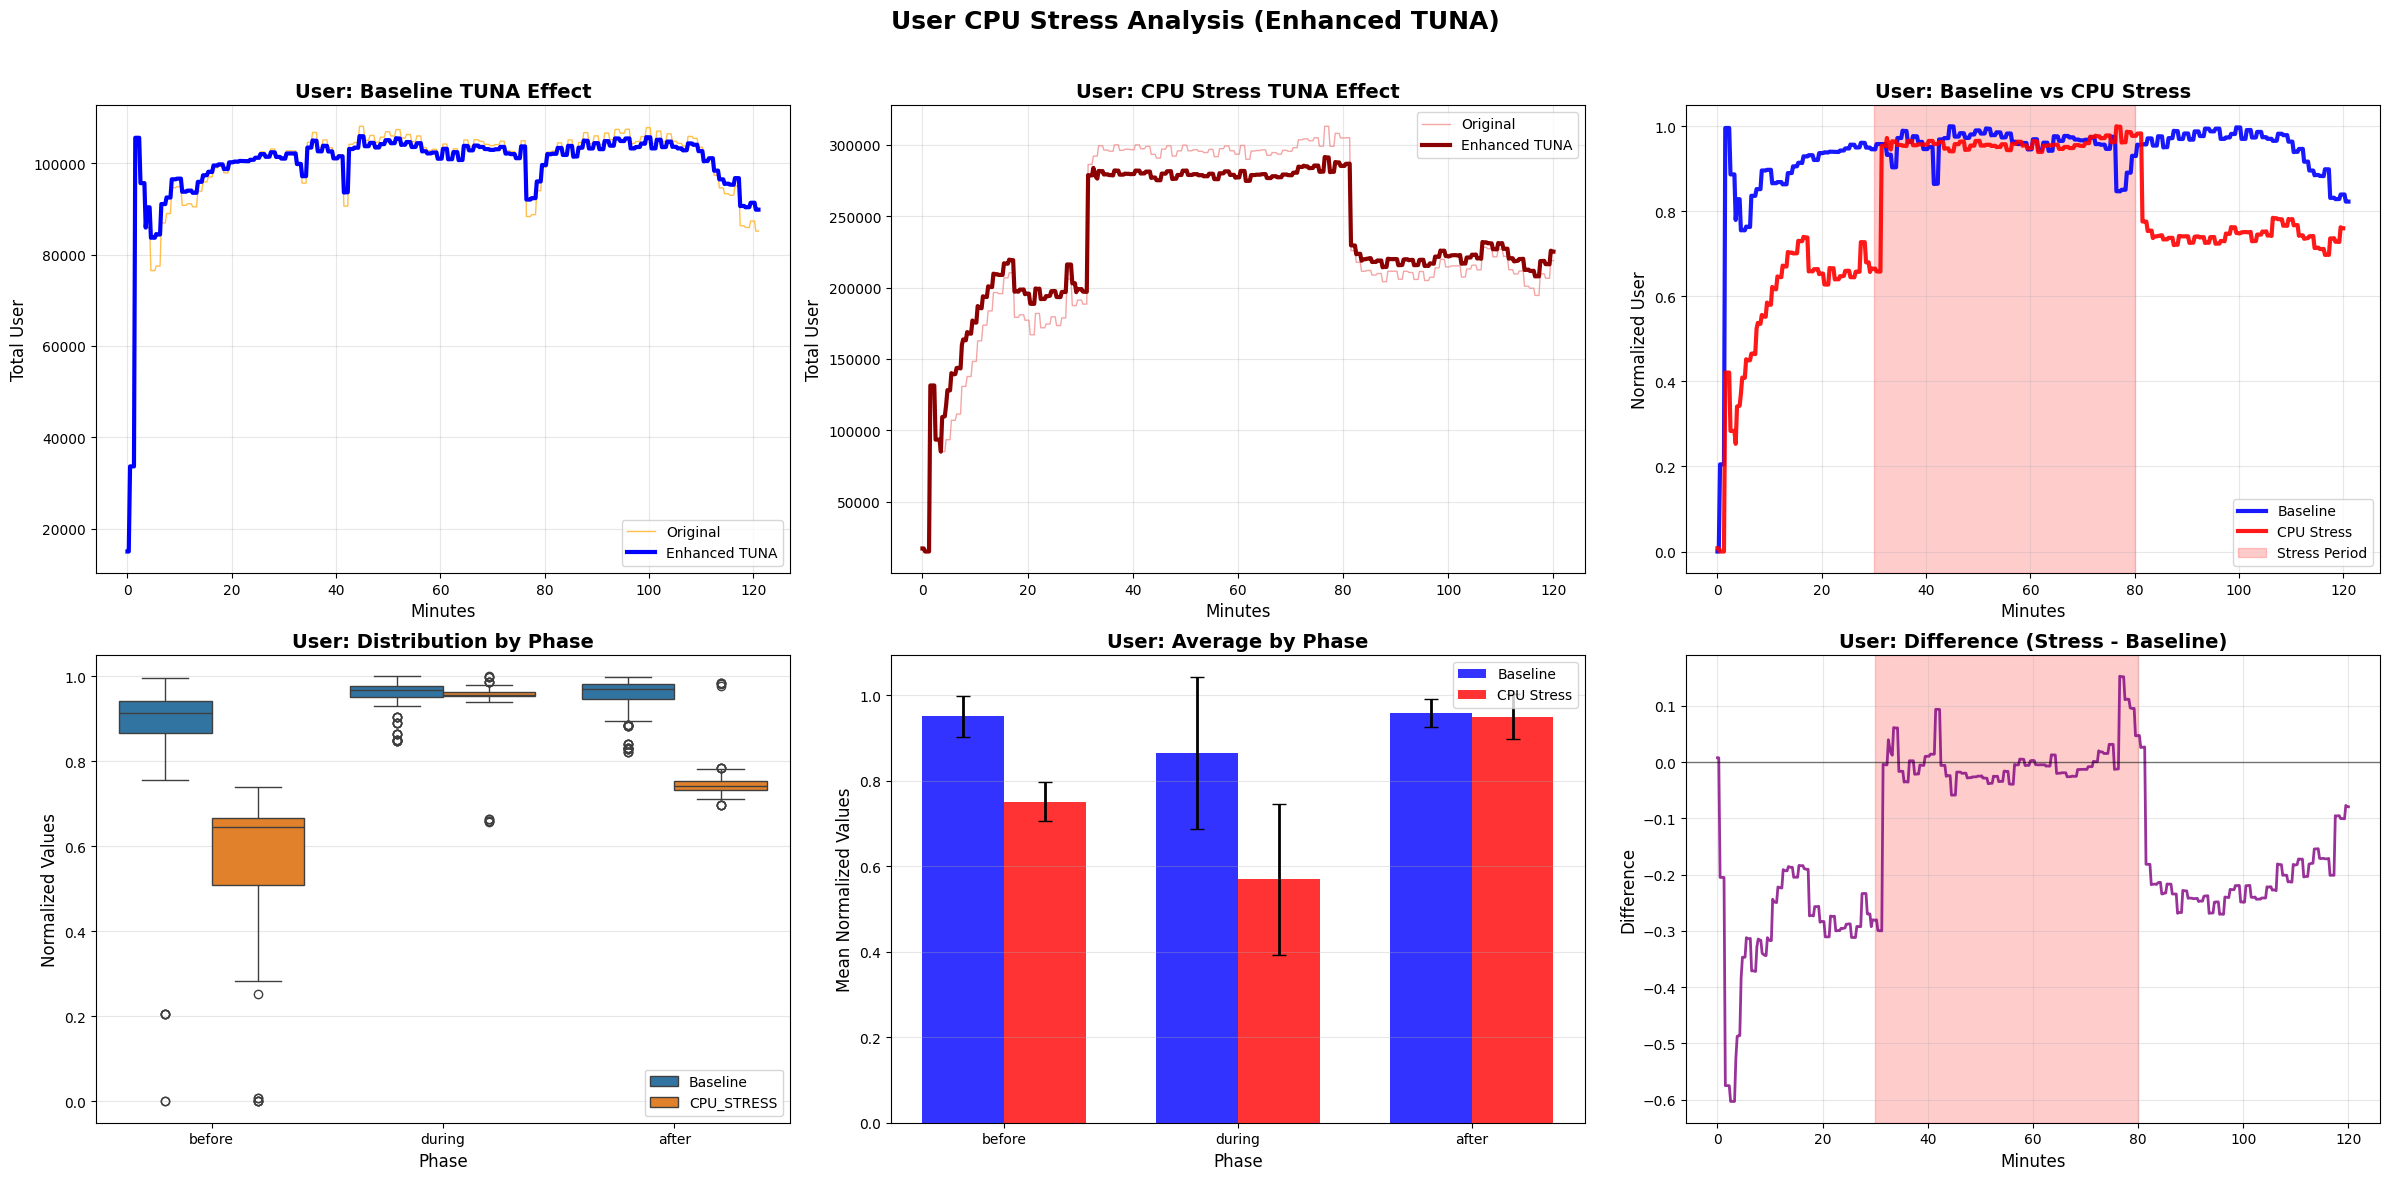

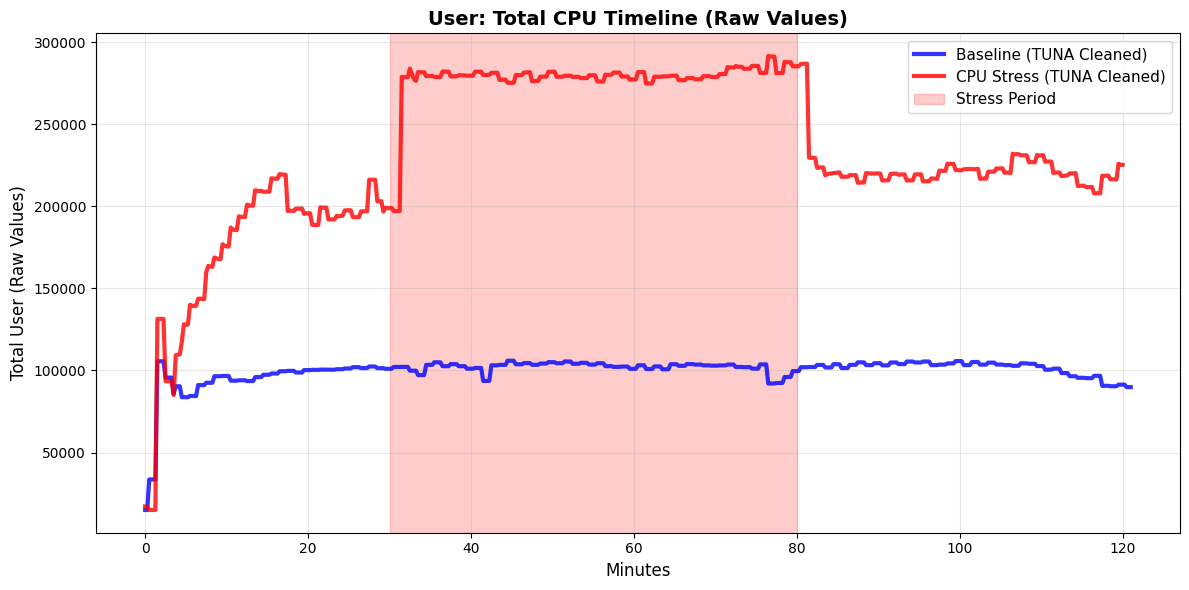


USER - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9509  0.0477  0.8228  0.9975
before  0.8644  0.1779  0.0000  0.9960
during  0.9579  0.0331  0.8471  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7508  0.0457  0.6975  0.9832
before  0.5692  0.1763  0.0000  0.7399
during  0.9502  0.0521  0.6583  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 12.91, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  1.76, p=  0.0793 (❌ NOT SIGNIFICANT)
  AFTER   : t= 38.56, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -34.15% (↘️ DECREASE)
  DURING  :   -0.80% (↘️ DECREASE)
  AFTER   :  -21.05% (↘️ DECREASE)

🔄 Analyzing Utilization...

📊 Plotting Enhanced TUNA cleaned data for Utilization...


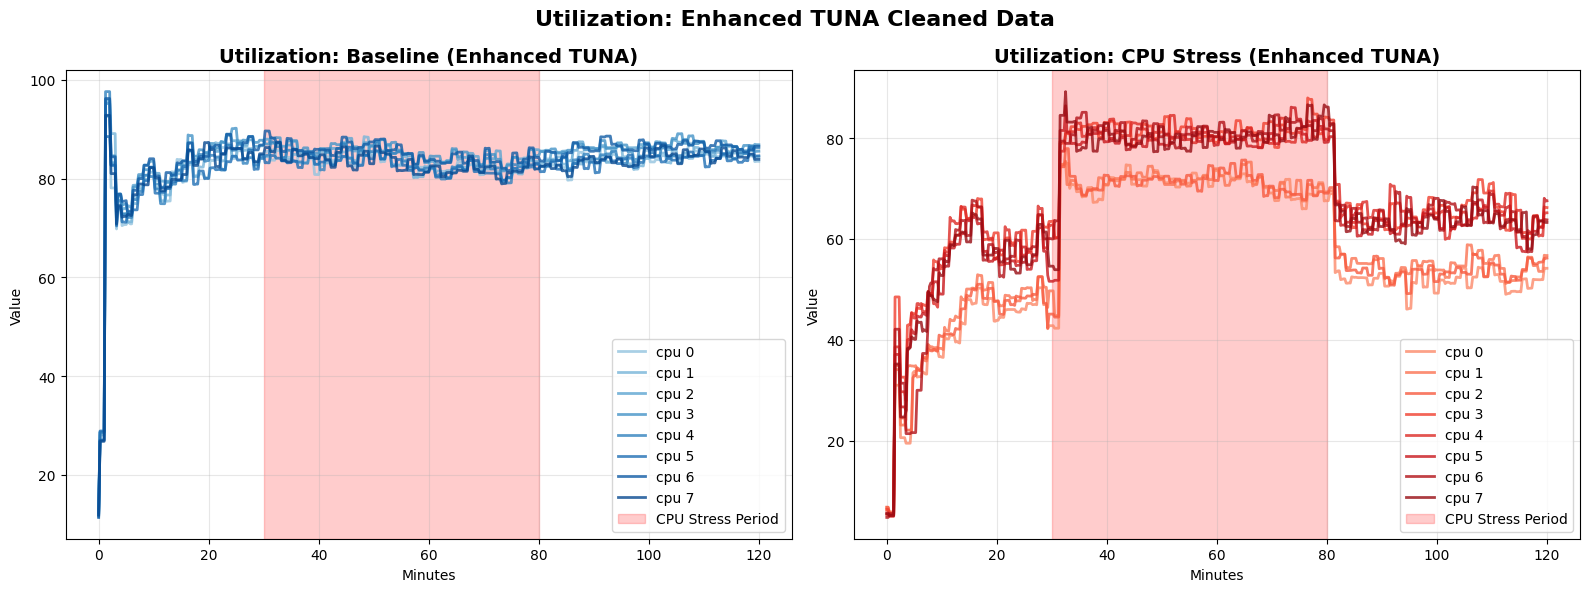

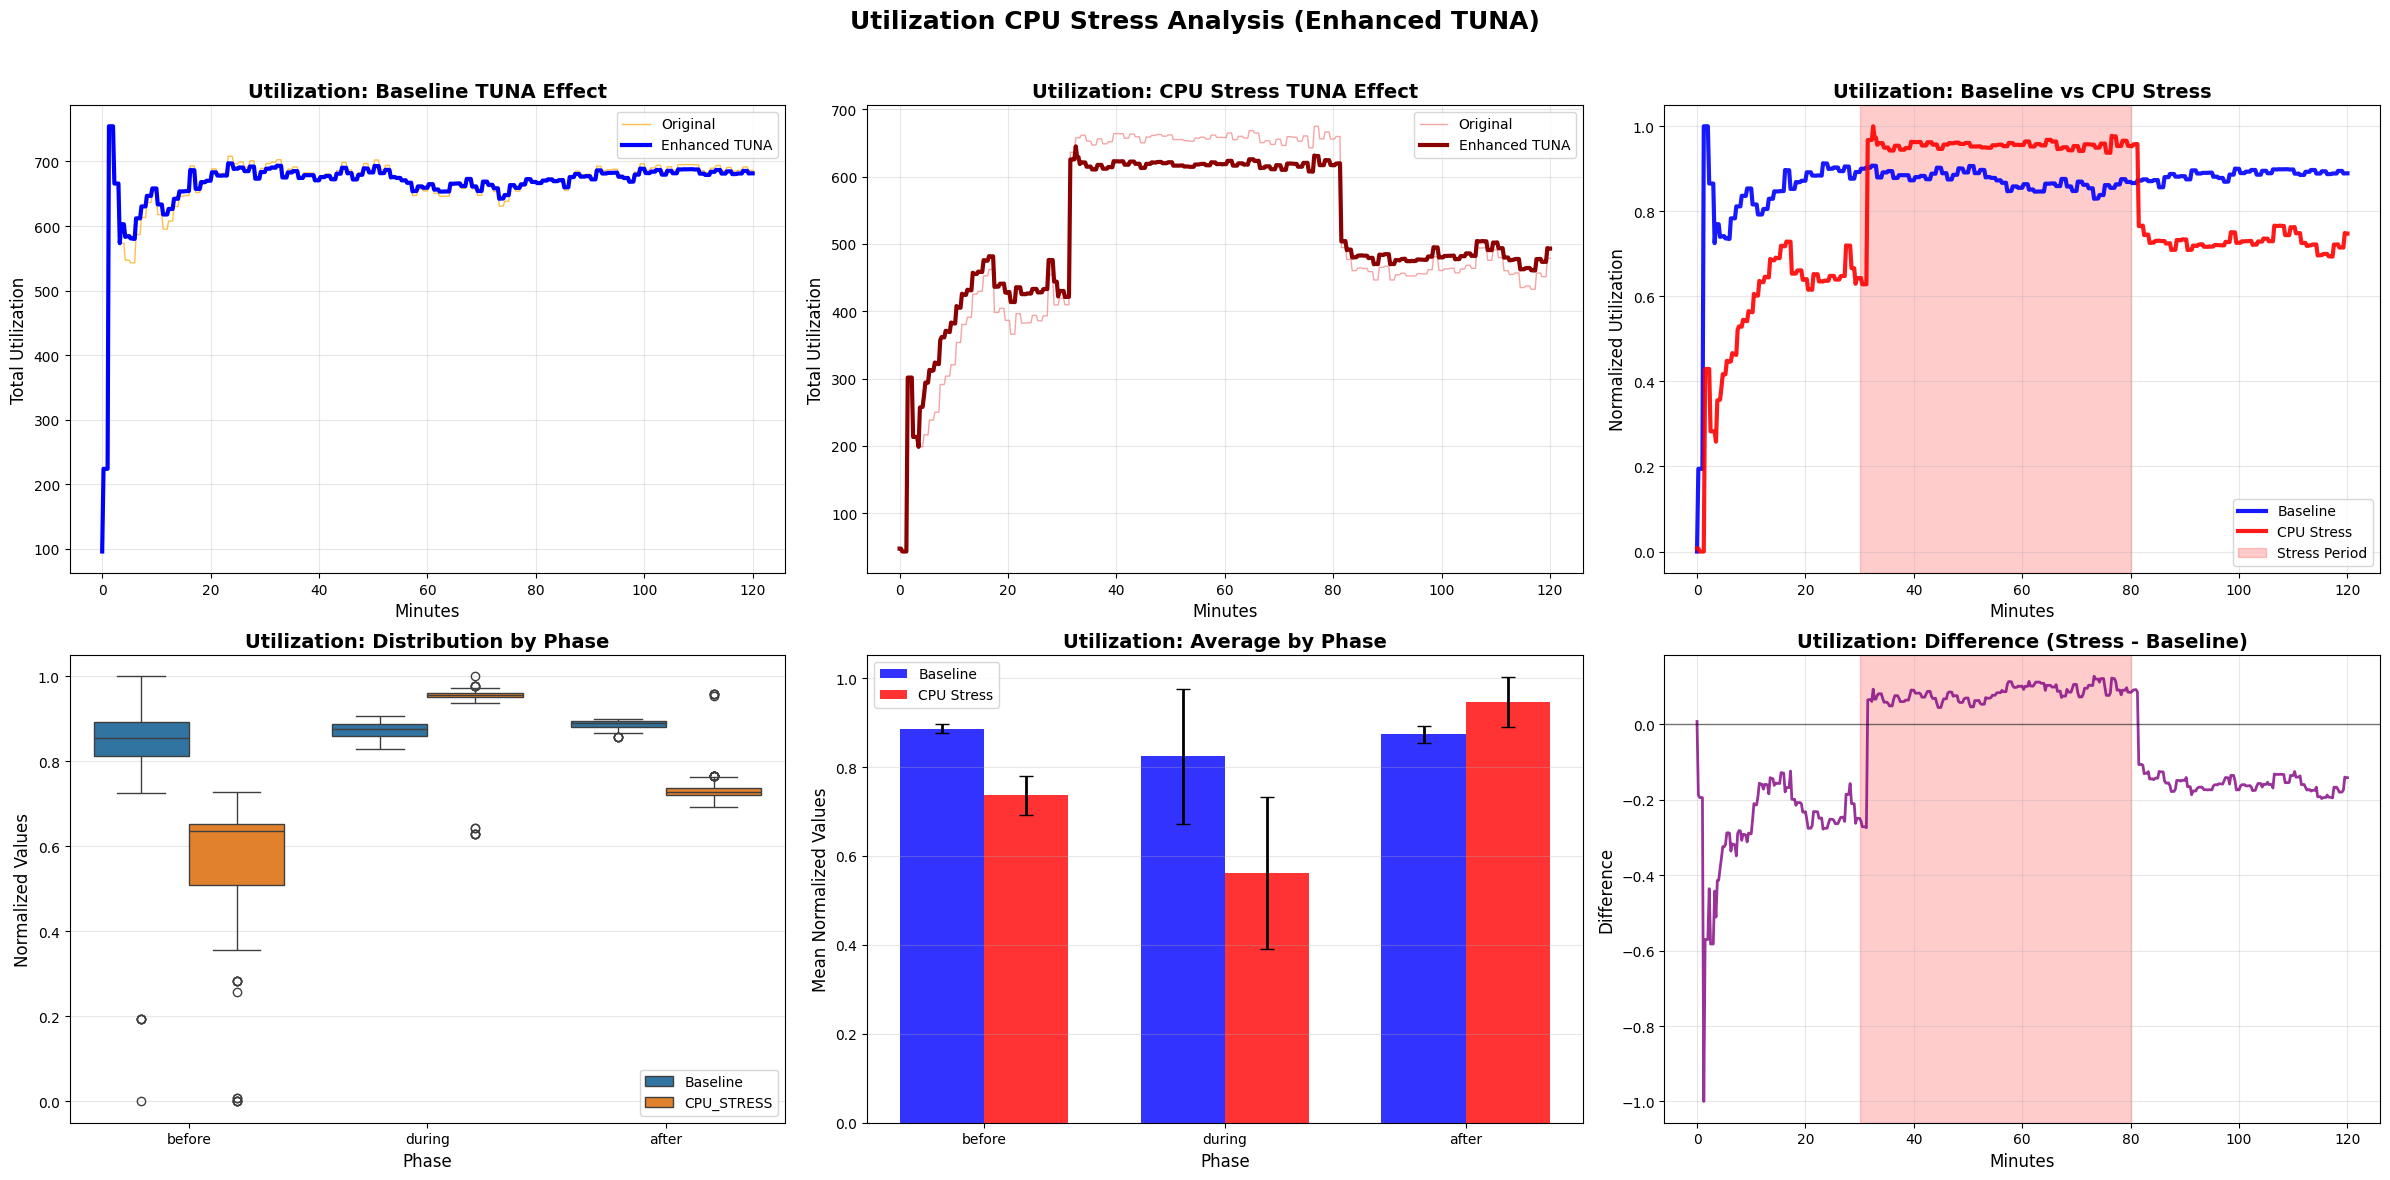

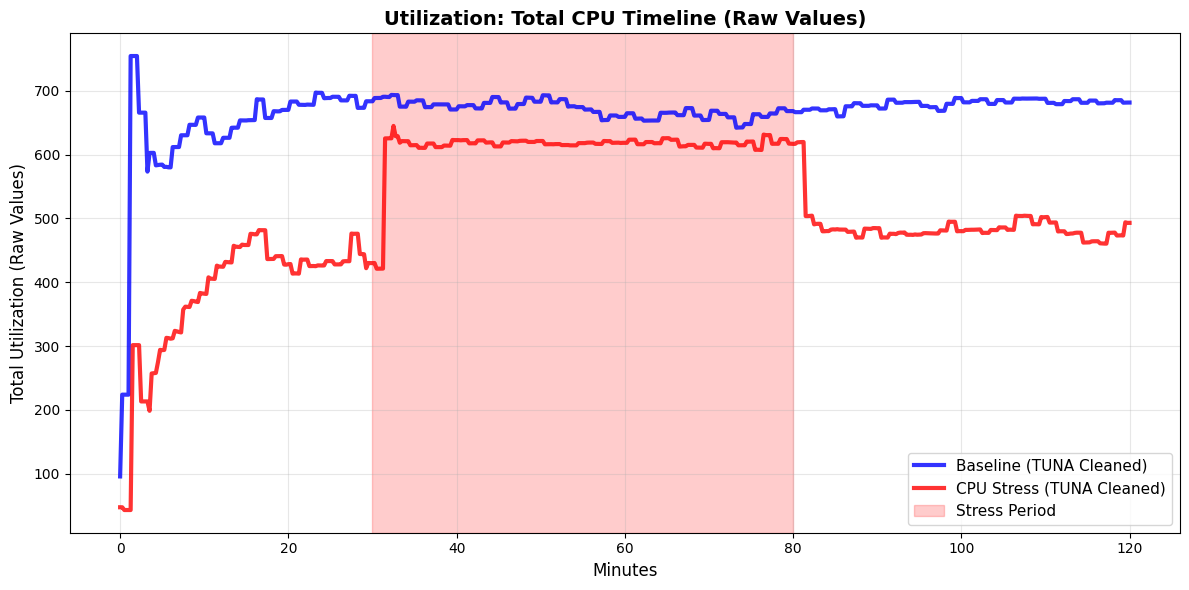


UTILIZATION - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8864  0.0102  0.8564  0.9005
before  0.8243  0.1516  0.0000  1.0000
during  0.8737  0.0186  0.8295  0.9075

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7360  0.0434  0.6936  0.9581
before  0.5612  0.1710  0.0000  0.7288
during  0.9463  0.0557  0.6283  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 12.61, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-17.53, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= 42.70, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -31.92% (↘️ DECREASE)
  DURING  :   +8.31% (↗️ INCREASE)
  AFTER   :  -16.97% (↘️ DECREASE)


In [25]:
# NORMALIZATION FUNCTION
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result


# ADD PHASE COLUMN
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df


# PLOT INDIVIDUAL CPU COLUMNS (UPDATED)
def plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Use the corrected cpu column filter
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]
    
    if len(cpu_cols) == 0:
        print(f"No CPU columns found in {dataset_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[cpu_col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax1.set_title(f'{dataset_name}: Baseline (Enhanced TUNA)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # CPU Stress Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax2.plot(cpu_stress_df['Minutes'], cpu_stress_df[cpu_col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax2.set_title(f'{dataset_name}: CPU Stress (Enhanced TUNA)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.suptitle(f'{dataset_name}: Enhanced TUNA Cleaned Data', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# MAIN ANALYSIS FUNCTION 
def analyze_and_plot_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Use the corrected cpu column filter
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]
    
    print(f"\n📊 Plotting Enhanced TUNA cleaned data for {dataset_name}...")
    plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes)
    
    cpu_stress_norm = normalize_df(cpu_stress_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Use TUNA-cleaned Total_CPU_TUNA if available
    if 'Total_CPU_TUNA' in cpu_stress_df.columns:
        cpu_stress_df['Total'] = cpu_stress_df['Total_CPU_TUNA']
        baseline_df['Total'] = baseline_df['Total_CPU_TUNA']
    else:
        cpu_stress_df['Total'] = cpu_stress_df[cpu_cols].sum(axis=1)
        baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals (with safe division)
    cpu_stress_range = cpu_stress_df['Total'].max() - cpu_stress_df['Total'].min()
    baseline_range = baseline_df['Total'].max() - baseline_df['Total'].min()
    
    if cpu_stress_range > 0:
        cpu_stress_norm['Total'] = (cpu_stress_df['Total'] - cpu_stress_df['Total'].min()) / cpu_stress_range
    else:
        cpu_stress_norm['Total'] = 0
        
    if baseline_range > 0:
        baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / baseline_range
    else:
        baseline_norm['Total'] = 0
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'CPU_STRESS': cpu_stress_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # COMPARISON PLOTS
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline TUNA effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Original', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='Enhanced TUNA', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS TUNA effect
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[cpu_cols].sum(axis=1), 
             label='Original', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df['Total'], 
             label='Enhanced TUNA', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU Stress TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm['Total'], 
             label='CPU Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Difference (Stress - Baseline)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} CPU Stress Analysis (Enhanced TUNA)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

    plot_cumulative_cpu_raw(dataset_name, cpu_stress_clean, baseline_clean, delay, duration)
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - ENHANCED TUNA ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'cpu_columns': cpu_cols
    }

def plot_cumulative_cpu_raw(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    """
    Plot only cumulative CPU timeline (raw values, not normalized)
    """
    
    # Get total CPU values
    stress_total = cpu_stress_df['Total_CPU_TUNA'] if 'Total_CPU_TUNA' in cpu_stress_df.columns else cpu_stress_df[[col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]].sum(axis=1)
    baseline_total = baseline_df['Total_CPU_TUNA'] if 'Total_CPU_TUNA' in baseline_df.columns else baseline_df[[col for col in baseline_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]].sum(axis=1)
    
    # Single plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(baseline_df['Minutes'], baseline_total, 
             label='Baseline (TUNA Cleaned)', linewidth=3, color='blue', alpha=0.8)
    plt.plot(cpu_stress_df['Minutes'], stress_total, 
             label='CPU Stress (TUNA Cleaned)', linewidth=3, color='red', alpha=0.8)
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    
    plt.title(f'{dataset_name}: Total CPU Timeline (Raw Values)', fontweight='bold', fontsize=14)
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name} (Raw Values)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print simple summary
    baseline_mean = baseline_total.mean()
    stress_mean = stress_total.mean()
    difference = stress_mean - baseline_mean
    percent_change = (difference / baseline_mean) * 100 if baseline_mean != 0 else 0


# RUN ANALYSIS (FIXED)
print(f"\n{'='*80}")
print("COMPREHENSIVE CPU STRESS ANALYSIS - ENHANCED TUNA")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )